# Delay Line Implementation

In [32]:
import numpy as np
import math


# signal = np.array([0, 1, 2, 3, 4, 5, 4, 3, 2, 1, 0])
## Test with sinusoidal signal
fs = 8000
f = 400
time = np.arange(0, 0.5, 1/fs)
signal = np.sin(2 * np.pi * f * time)


# signal = np.zeros(150)
# signal[2] = 1
# print(np.shape(signal))
N = 2048

A = np.zeros(N)

rptr = 0
wptr = 0
M = 10
def set_delay(M):
    global rptr
    rptr = wptr - M
    if (rptr < 0):
        rptr += N

def delay_line(x):
    
    global rptr
    global wptr
    global A
    
    A[wptr] = x
    wptr += 1

#    y = A[rptr]
    rpi = math.floor(rptr)
    a = rptr - rpi
    y = a * A[rpi + 1] + (1 - a) * A[rpi]
    rptr += 1

    if (wptr >= N - 1):
        wptr -= (N)
    if (rptr >= N - 1):
        rptr -= (N)
    return y

set_delay(M)
rptr = rptr + 0.4
a = np.zeros_like(signal)
for i in range(0, len(signal)):
    a[i] = delay_line(signal[i])
    # print(a)
A[-4]

0.9510565162951612

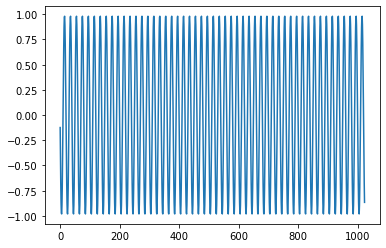

In [33]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(0,1024), a[2000:3024])
plt.show()

# Continuous varying delay line implementation

In [39]:
g =  - 5 * 1/343

A = np.zeros(N)
rptr = 0
wptr = 0
M = 1024
def set_delay(M):
    global rptr
    rptr = wptr - M
    if (rptr < 0):
        rptr += N

def delay_line(x):
    
    global rptr
    global wptr
    global A
    global g
    
    A[wptr] = x
    wptr += 1

    rpi = math.floor(rptr)
    a = rptr - rpi
    y = a * A[rpi + 1] + (1 - a) * A[rpi]
    rptr += (1 - g)

    if (wptr >= N - 1):
        wptr -= (N)
    if (rptr >= N - 1):
        rptr -= (N)
    return y

set_delay(M)

## Test with sinusoidal signal
fs = 8000
f = 400
time = np.arange(0, 6, 1/fs)
signal = np.sin(2 * np.pi * f * time)

a = np.zeros_like(signal)
for i in range(0, len(signal)):
    a[i] = delay_line(signal[i])
    if i == math.floor(len(signal) / 2):
        g = -g

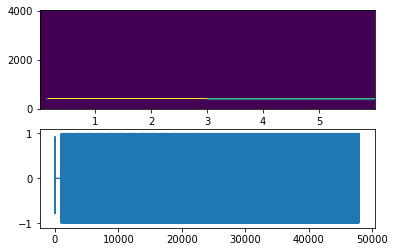

In [40]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy import signal as sig

ff, tt, Sxx = sig.spectrogram(a, fs)
plt.subplot(2,1,1)
plt.pcolormesh(tt, ff, Sxx, shading = 'auto')

plt.subplot(2,1,2)
# plt.plot(range(0, 1024), a[2048:2048 + 1024])
plt.plot(a)
# plt.show()


wavfile.write('prova.wav', fs, 0.02*a)

# Continuously Variable Delay with Point - Line Distance
This method should involve ~ half the number of operations with respect to the above procedures, when vector values are considered

In [41]:
# Compute distance from microphone to line

# Straight Trajectory between starting and end point
P1 = np.array([3,20])
P2 = np.array([3, -5])
P3 = np.array([0,0])

v = 10   # speed of sound source


# Compute distance from MIC (origin) to line
dline = np.abs((P2[0] - P1[0]) * (P1[1] - P3[1]) - (P1[0] - P3[0]) * (P2[1] - P1[1])) / np.sqrt(np.sum((P2-P1)**2))
dline2 = dline ** 2
# What happens when the line is exactly on the x or y axes?

# Compute distance from P0 to projection of MIC on the line
l2 = np.sum((P1-P2)**2)
t = np.sum((P3 - P1) * (P2 - P1)) / l2
P_proj = P1 + t * (P2 - P1)
dproj = np.sqrt(np.sum((P1 - P_proj) ** 2))

# Compute initial distance from MIC to P1
dinit = np.sqrt(dproj ** 2 + dline ** 2)

# Compute time delay in number of samples
c = 343
tau_init = dinit / c

M_init = tau_init * fs
print(M_init)

delays_sec = []
delays_smp = []
delays_sec.append(tau_init)

471.6909251581734


In [42]:
# Define delay line
N = 1024
A = np.zeros(N)

# Windowed Sinc Function
sinc_samples = 81
sinc_window = np.hanning(sinc_samples)


rptr = 0
wptr = 0
M = np.floor(M_init)    # Define initial delay
delays_smp.append(M)
# print(d)
def set_delay(M):
    global rptr
    rptr = wptr - M
    if (rptr < 0):
        rptr += N

def frac_delay_sinc(delay):
    global sinc_samples
    global sinc_window

    return sinc_window * np.sinc(np.arange(0,sinc_samples) - (sinc_samples - 1) / 2 - delay)

def frac_delay_lagrange(N, delay):
    n = np.arange(0,N+1)
    h = np.ones(N+1)

    for k in range(0,N+1):
        # Find index n != k
        index = []
        for j in range(0,N+1):
            if j != k:
                index.append(j)
        
        h[index] = h[index] * (delay - k) / (n[index] - k)

    return h

def delay_line(x):
    global rptr
    global wptr
    global A
    global v
    global dproj
    global c
    global fs
    global delays_smp
    
    A[wptr] = x
    wptr += 1

    rpi = math.floor(rptr)
    a = rptr - rpi
    # Linear Interpolation
    y1 = a * A[rpi + 1] + (1 - a) * A[rpi]
    
    # Sinc Interpolation -> Windowed Sinc function
    h_sinc = frac_delay_sinc(a)
    
    y2 = 0
    for i in range(0, sinc_samples):
        y2 = y2 + h_sinc[i]*A[np.mod(rpi + i - math.floor(sinc_samples/2), len(A))]
    
    # Lagrange Interpolation
    order = 5
    h_lagrange = frac_delay_lagrange(order, a)
    y3 = 0

    for i in range(0, len(h_lagrange)):
        y3 = y3 + h_lagrange[i] * A[np.mod(rpi + i, len(A))]

    # Update delay
    dproj -= v / fs
    
    d = dline2 + dproj ** 2
    tau = np.sqrt(d) / c
    M = tau * fs
    rptr = wptr - M

    # For the plots, remove later
    delays_sec.append(tau)
    delays_smp.append(M)

    if (rptr < 0):
        rptr += N
    if (wptr >= N - 1):
        wptr -= (N)
    if (rptr >= N - 1):
        rptr -= (N)
    return y1, y2, y3, d

set_delay(M)
a = 0
signal = 0
## Test with signal
fs = 8000
f = 400
time = np.arange(0, 6, 1/fs)

# Sinusoidal
signal = np.sin(2 * np.pi * f * time)

# Noise
# signal = np.random.randn(len(time))

# Train impulse
# signal = np.zeros_like(time)
# signal[::500] = 1

aa = np.zeros_like(signal)
bb = np.zeros_like(signal)
cc = np.zeros_like(signal)
for i in range(0, len(signal)):
    [sample1, sample2, sample3, d] = delay_line(signal[i])
    attenuation = 1 / (4 * np.pi * d)
    # attenuation = 1
    aa[i] = attenuation * sample1
    bb[i] = attenuation * sample2
    cc[i] = attenuation * sample3
    # a[i] = delay_line(signal[i])



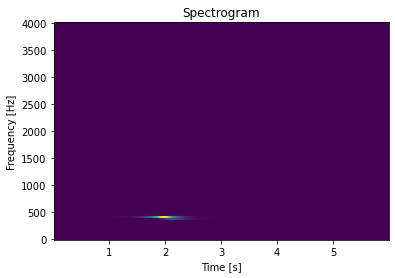

In [44]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy import signal as sig

ff, tt, Sxx = sig.spectrogram(bb, fs)
# plt.subplot(2,1,1)
plt.pcolormesh(tt, ff, Sxx, shading = 'auto')
plt.title('Spectrogram')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
# plt.subplot(2,1,2)
# plt.plot(range(0, 2048), a[1024:1024+2048])
plt.show()

wavfile.write('prova.wav', fs, 1*bb)

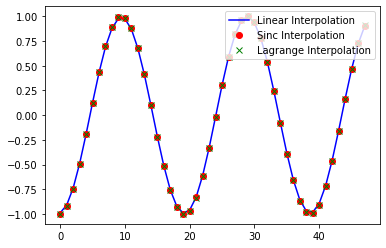

In [23]:
smp = 2048
plot_len = 48
plt.plot(aa[smp:smp + plot_len], 'b')
plt.plot(bb[smp:smp + plot_len], 'ro')
plt.plot(cc[smp:smp + plot_len], 'gx')
plt.legend(['Linear Interpolation', 'Sinc Interpolation', 'Lagrange Interpolation'], loc = 'upper right')

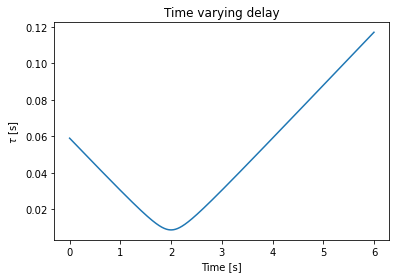

In [24]:
plt.plot(np.arange(len(delays_sec)) / fs, delays_sec)
plt.xlabel('Time [s]')
plt.ylabel(r'$\tau$ [s]')
plt.title('Time varying delay')
plt.show()

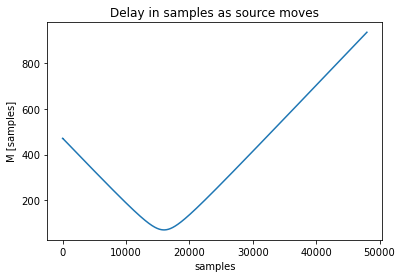

In [25]:
plt.plot(delays_smp)
plt.xlabel('samples')
plt.ylabel('M [samples]')
plt.title('Delay in samples as source moves')
plt.show()

# First Reflection in an augmented 2D scenario

In [26]:
# Compute distance from microphone to line

# Straight Trajectory between starting and end point
P1 = np.array([4,10])
P2 = np.array([4, -5])
P3 = np.array([0,0])

# Assume source and receiver lie on the same plane above the ground
height = 1

v = 5   # speed of sound source


# Compute distance from MIC (origin) to line
dline = np.abs((P2[0] - P1[0]) * (P1[1] - P3[1]) - (P1[0] - P3[0]) * (P2[1] - P1[1])) / np.sqrt(np.sum((P2-P1)**2))
dline2 = dline ** 2
# What happens when the line is exactly on the x or y axes?

# Compute distance from P0 to projection of MIC on the line
l2 = np.sum((P1-P2)**2)
t = np.sum((P3 - P1) * (P2 - P1)) / l2
P_proj = P1 + t * (P2 - P1)
dproj = np.sqrt(np.sum((P1 - P_proj) ** 2))

# Compute initial distance from MIC to P1
dinit = np.sqrt(dproj ** 2 + dline ** 2)

# Compute initial distance from first reflection to MIC
dinit_refl = np.sqrt(dinit ** 2 + (2 * height) ** 2)

# Compute time delay in number of samples
c = 343
tau_init = dinit / c
tau_init_refl = dinit_refl / c
M_init = tau_init * fs
M_init_refl = tau_init_refl * fs
print(M_init)
print(M_init_refl)

delays_sec = []
delays_sec_refl = []

delays_sec.append(tau_init)
delays_sec_refl.append(tau_init_refl)

251.20302307332963
255.49740291786176


In [27]:
# Define delay line
N = 48000
A = np.zeros(N)

rptr = 0
rptr2 = 0
wptr = 0
M1 = np.floor(M_init)    # Define initial delay
M2 = np.floor(M_init_refl)  # Initial delay for first reflection

def set_delay(M1, M2):
    global rptr
    global rptr2

    rptr = wptr - M1
    rptr2 = wptr - M2
    if (rptr < 0):
        rptr += N
    if (rptr2 < 0):
        rptr2 += N

def delay_line(x):
    
    global rptr
    global rptr2
    global wptr
    global A
    global v
    global dproj
    global c
    global fs
    global delays_sec
    global delays_sec_refl

    A[wptr] = x
    wptr += 1

    rpi = math.floor(rptr)
    a = rptr - rpi
    ydir = a * A[rpi + 1] + (1 - a) * A[rpi]
    
    rpi = math.floor(rptr2)
    a = rptr2 - rpi
    yrefl = a * A[rpi + 1] + (1 - a) * A[rpi]

    
    # Update delay
    dproj -= v / fs
    d = dline2 + dproj ** 2
    drefl = d + (2 * height) ** 2

    tau = np.sqrt(d) / c
    tau_refl = np.sqrt(drefl) / c
    M = tau * fs
    M2 = tau_refl * fs
    rptr = wptr - M
    rptr2 = wptr - M2

    # Compute attentuated output
    y = 1 / (4 * np.pi * np.sqrt(d)) * ydir + 1 / (4 * np.pi * np.sqrt(drefl)) * yrefl
    # For the plots, remove later
    delays_sec.append(tau)
    
    
    if (rptr < 0):
        rptr += N
    if (rptr2 < 0):
        rptr2 += N
    if (wptr >= N - 1):
        wptr -= (N)
    if (rptr >= N - 1):
        rptr -= (N)
    if (rptr2 >= N - 1):
        rptr2 -= (N)
    return y

set_delay(M1, M2)
a = 0
signal = 0
## Test with signal
fs = 8000
f = 400
time = np.arange(0, 6, 1/fs)

# Sinusoidal
# signal = np.sin(2 * np.pi * f * time)

# Noise
# signal = np.random.randn(len(time))

# Train impulse
signal = np.zeros_like(time)
signal[::100] = 1

a = np.zeros_like(signal)
for i in range(0, len(signal)):
    a[i] = delay_line(signal[i])
    # a[i] = delay_line(signal[i])



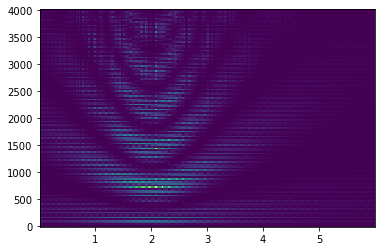

In [28]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy import signal as sig

ff, tt, Sxx = sig.spectrogram(a, fs)
# plt.subplot(2,1,1)
plt.pcolormesh(tt, ff, Sxx, shading = 'auto')

# plt.subplot(2,1,2)
# plt.plot(range(0, 2048), a[1024:1024+2048])
plt.show()

wavfile.write('prova.wav', fs, 0.5*a)

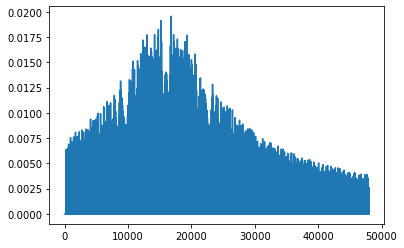

In [29]:
plt.plot(a)
plt.show()

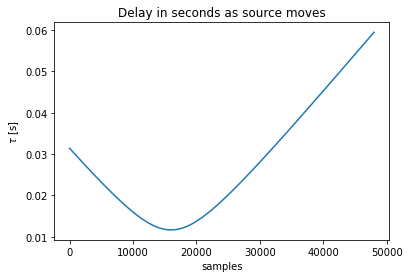

In [30]:
plt.plot(delays_sec)
plt.xlabel('samples')
plt.ylabel(r'$\tau$ [s]')
plt.title('Delay in seconds as source moves')
plt.show()

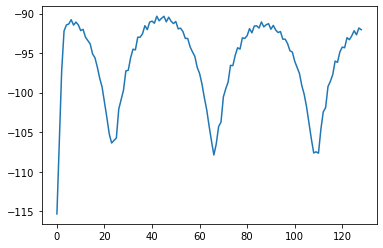

In [31]:
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements.
order = 1
fs = 8000       # sample rate, Hz
cutoff = 600  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.

# Select Time frames
tt_down = tt[0::5]
Sxx_down = Sxx[:,0::5]

b, a = butter_lowpass(cutoff, fs, order)
Sxx_lp = np.zeros_like(Sxx_down)
for i in range(len(tt_down)):
    Sxx_lp[:,i]= butter_lowpass_filter(Sxx_down[:,i], cutoff, fs, order)


plt.plot(10.0*np.log10(Sxx_lp[:,5]))
plt.show()

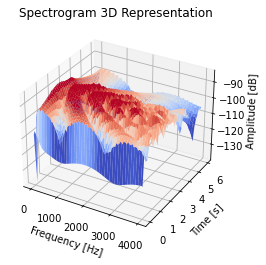

In [19]:
from matplotlib import cm
from matplotlib import colors
# %matplotlib widget

divnorm=colors.Normalize(vmin=-110, vmax=-90)
# pcolormesh(your_data, cmap="coolwarm", norm=divnorm)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.title('Spectrogram 3D Representation')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Time [s]')
ax.set_zlabel('Amplitude [dB]')
ax.plot_surface(ff[:, None], tt_down[None, :], 10.0*np.log10(Sxx_lp), cmap = cm.coolwarm, norm = divnorm)
plt.show()

In [20]:
# Test Animated Plot
import imageio
import os

gif_name = 'movie'
n_frames = 10

filenames = []
for i in np.arange(0, len(tt_down)):
    plt.plot(ff, 10.0*np.log10(Sxx_lp[:,i]))
    plt.ylim(-122,-85)
    plt.xlim(-100, 4100)
    plt.title(f'FFT, t = %f [s]' % tt_down[i])
    plt.ylabel('Amplitude [dB]')
    plt.xlabel('f')

    filename = f'{i}.png'
    filenames.append(filename)

    plt.savefig(filename)
    plt.close()

with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

for filename in set(filenames):
    os.remove(filename)

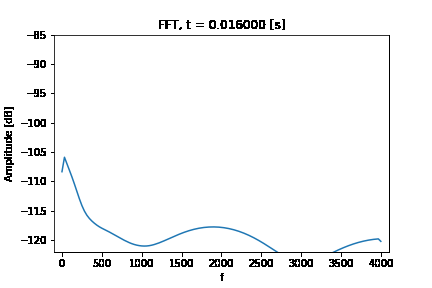

In [22]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

from pathlib import Path
gifPath = Path("mygif.gif")

# Display GIF in Jupyter, CoLab, IPython ---- UNCOMMENT LINES BELOW
with open(gifPath,'rb') as f:
   display.Image(data=f.read(), format='png')


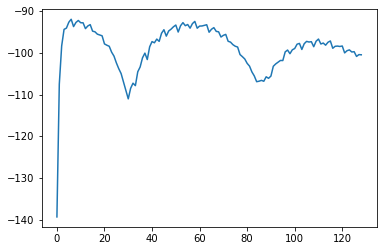

In [26]:
plt.plot(10*np.log10(Sxx_lp[:,1]))

# Delay Line with Absorption Filter

In [28]:
# Compute distance from microphone to line

# Straight Trajectory between starting and end point
P1 = np.array([4,10])
P2 = np.array([4, -5])
P3 = np.array([0,0])

# Assume source and receiver lie on the same plane above the ground
height = 1

v = 5   # speed of sound source


# Compute distance from MIC (origin) to line
dline = np.abs((P2[0] - P1[0]) * (P1[1] - P3[1]) - (P1[0] - P3[0]) * (P2[1] - P1[1])) / np.sqrt(np.sum((P2-P1)**2))
dline2 = dline ** 2
# What happens when the line is exactly on the x or y axes?

# Compute distance from P0 to projection of MIC on the line
l2 = np.sum((P1-P2)**2)
t = np.sum((P3 - P1) * (P2 - P1)) / l2
P_proj = P1 + t * (P2 - P1)
dproj_init = np.sqrt(np.sum((P1 - P_proj) ** 2))

# Compute initial distance from MIC to P1
dinit = np.sqrt(dproj_init ** 2 + dline ** 2)

# Compute initial distance from first reflection to MIC
dinit_refl = np.sqrt(dinit ** 2 + (2 * height) ** 2)

# Compute time delay in number of samples
c = 343
tau_init = dinit / c
tau_init_refl = dinit_refl / c
M_init = tau_init * fs
M_init_refl = tau_init_refl * fs
print(M_init)
print(M_init_refl)

delays_sec = []
delays_sec_refl = []

delays_sec.append(tau_init)
delays_sec_refl.append(tau_init_refl)

251.20302307332963
255.49740291786176


In [29]:
def set_delay(M1, M2):
    global rptr
    global rptr2

    rptr = wptr - M1
    rptr2 = wptr - M2
    if (rptr < 0):
        rptr += N
    if (rptr2 < 0):
        rptr2 += N

def delay_line(x):
    
    global rptr
    global rptr2
    global wptr
    global A
    global v
    global dproj
    global c
    global fs
    global delays_sec
    global delays_sec_refl
    
    A[wptr] = x
    wptr += 1

    rpi = math.floor(rptr)
    a = rptr - rpi
    ydir = a * A[rpi + 1] + (1 - a) * A[rpi]
    
    rpi = math.floor(rptr2)
    a = rptr2 - rpi
    yrefl = a * A[rpi + 1] + (1 - a) * A[rpi]

    # Apply absorption filter
    # alpha = 1 - 0.8
    # yrefl = alpha * yrefl
    
    # Update delay
    dproj -= v / fs
    d = dline2 + dproj ** 2
    drefl = d + (2 * height) ** 2

    tau = np.sqrt(d) / c
    tau_refl = np.sqrt(drefl) / c
    M1 = tau * fs
    M2 = tau_refl * fs
    rptr = wptr - M1
    rptr2 = wptr - M2

    # Compute attentuated output
    y = 1 / (4 * np.pi * np.sqrt(d)) * ydir + 1 / (4 * np.pi * np.sqrt(drefl)) * yrefl
    # For the plots, remove later
    delays_sec.append(tau)
    
    
    if (rptr < 0):
        rptr += N
    if (rptr2 < 0):
        rptr2 += N
    if (wptr >= N - 1):
        wptr -= (N)
    if (rptr >= N - 1):
        rptr -= (N)
    if (rptr2 >= N - 1):
        rptr2 -= (N)
    return ydir, yrefl, d, drefl

# Define delay line
N = 48000
A = np.zeros(N)

rptr = 0
rptr2 = 0
wptr = 0
M1 = np.floor(M_init)    # Define initial delay
M2 = np.floor(M_init_refl)  # Initial delay for first reflection
dproj = dproj_init

set_delay(M1, M2)
a = 0
signal = 0
## Test with signal
fs = 8000
f = 400
time = np.arange(0, 6, 1/fs)

# Sinusoidal
signal = np.sin(2 * np.pi * f * time)

# Noise
# signal = np.random.randn(len(time))

# Train impulse
# signal = np.zeros_like(time)
# signal[::100] = 1

adir = np.zeros_like(signal)
arefl = np.zeros_like(signal)

# Compute attenuation depending on distance
for i in range(0, len(signal)):
    [ydir, yrefl, ddir, drefl] = delay_line(signal[i])
    adir[i] = ydir#1/(4*np.pi*ddir) * ydir
    arefl[i] = yrefl#1/(4*np.pi*drefl) * yrefl

# Filter using Absorption Filter
from scipy.io import loadmat
absorption_filter = loadmat('h_fir.mat')
absorption_filter = absorption_filter['h_fir']
absorption_filter = [row[0] for row in absorption_filter]
# absorption_filter = np.zeros(9)
# absorption_filter[0] = 1
# print(absorption_filter)
reflected_component = np.convolve(arefl, absorption_filter)

# Compute Signal
# Zero - pad
direct_component = np.append(adir, np.zeros(len(absorption_filter) - 1))

# Sum
aa = direct_component + reflected_component

Text(0.5, 1.0, 'Test with Sinusoid')

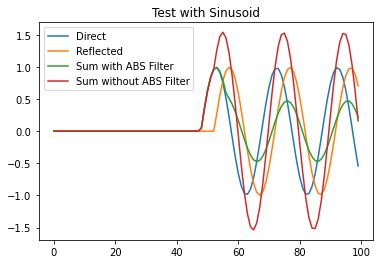

In [30]:
plt.plot(adir[200:300])
plt.plot(arefl[200:300])
plt.plot(aa[200:300])
plt.plot(adir[200:300] + arefl[200:300])
plt.legend(['Direct', 'Reflected', 'Sum with ABS Filter', 'Sum without ABS Filter'])
plt.title('Test with Sinusoid')

Text(0.5, 1.0, 'Spectrogram')

Text(0.5, 0, 'Time [s]')

Text(0, 0.5, 'Frequency [Hz]')

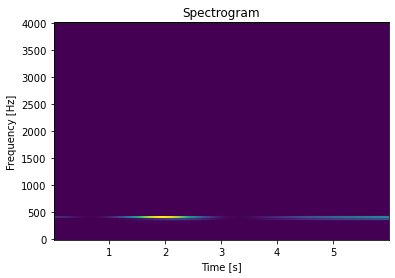

In [31]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy import signal as sig

ff, tt, Sxx = sig.spectrogram(aa, fs)
plt.pcolormesh(tt, ff, Sxx, shading = 'auto')
plt.title('Spectrogram')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.show()

wavfile.write('prova.wav', fs, 0.5*aa)

## Test with Impulse Train

In [32]:
# Define delay line
N = 48000
A = np.zeros(N)

rptr = 0
rptr2 = 0
wptr = 0
M1 = np.floor(M_init)    # Define initial delay
M2 = np.floor(M_init_refl)  # Initial delay for first reflection
dproj = dproj_init

set_delay(M1, M2)
a = 0
signal = 0
## Test with signal
fs = 8000
f = 400
time = np.arange(0, 6, 1/fs)

# Sinusoidal
# signal = np.sin(2 * np.pi * f * time)

# Noise
# signal = np.random.randn(len(time))

# Train impulse
signal = np.zeros_like(time)
signal[::100] = 1

adir = np.zeros_like(signal)
arefl = np.zeros_like(signal)

# Compute attenuation depending on distance
for i in range(0, len(signal)):
    [ydir, yrefl, ddir, drefl] = delay_line(signal[i])
    adir[i] = ydir#1/(4*np.pi*ddir) * ydir
    arefl[i] = yrefl#1/(4*np.pi*drefl) * yrefl

# Filter using Absorption Filter
from scipy.io import loadmat
absorption_filter = loadmat('h_fir.mat')
absorption_filter = absorption_filter['h_fir']
absorption_filter = [row[0] for row in absorption_filter]
# absorption_filter = np.zeros(9)
# absorption_filter[0] = 1
# print(absorption_filter)
reflected_component = np.convolve(arefl, absorption_filter)

# Compute Signal
# Zero - pad
direct_component = np.append(adir, np.zeros(len(absorption_filter) - 1))

# Sum
aa = direct_component + reflected_component

Text(0.5, 1.0, 'Spectrogram')

Text(0.5, 0, 'Time [s]')

Text(0, 0.5, 'Frequency [Hz]')

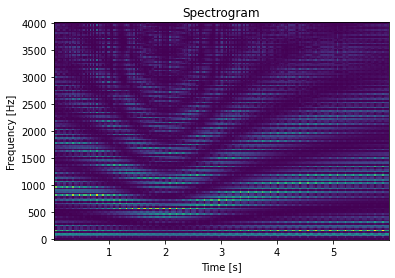

Text(0.5, 1.0, 'FFT at Single Time Frame')

Text(0.5, 0, 'Frequency Bin')

Text(0, 0.5, 'Amplitude [dB]')

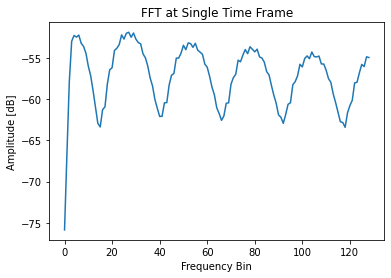

Text(0.5, 0.92, 'Spectrogram 3D Representation')

Text(0.5, 0, 'Frequency [Hz]')

Text(0.5, 0, 'Time [s]')

Text(0.5, 0, 'Amplitude [dB]')

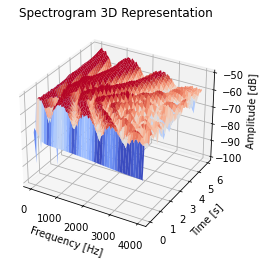

In [33]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy import signal as sig

ff, tt, Sxx = sig.spectrogram(aa, fs)
plt.pcolormesh(tt, ff, Sxx, shading = 'auto')
plt.title('Spectrogram')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.show()

# wavfile.write('prova.wav', fs, 0.5*aa)

# Filter requirements.
order = 1
fs = 8000       # sample rate, Hz
cutoff = 600  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.

# Select Time frames
tt_down = tt[0::5]
Sxx_down = Sxx[:,0::5]

b, a = butter_lowpass(cutoff, fs, order)
Sxx_lp = np.zeros_like(Sxx_down)
for i in range(len(tt_down)):
    Sxx_lp[:,i]= butter_lowpass_filter(Sxx_down[:,i], cutoff, fs, order)


plt.plot(10.0*np.log10(Sxx_lp[:,5]))
plt.title('FFT at Single Time Frame')
plt.xlabel('Frequency Bin')
plt.ylabel('Amplitude [dB]')
plt.show()

fig = plt.figure()
divnorm=colors.Normalize(vmin=-70, vmax=-55)
ax = fig.add_subplot(projection='3d')
plt.title('Spectrogram 3D Representation')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Time [s]')
ax.set_zlabel('Amplitude [dB]')
ax.plot_surface(ff[:, None], tt_down[None, :], 10.0*np.log10(Sxx_lp), cmap = cm.coolwarm, norm = divnorm)
plt.show()

In [34]:
# Test Animated Plot
import imageio
import os

filenames = []
for i in np.arange(0, len(tt_down)):
    plt.plot(ff, 10.0*np.log10(Sxx_lp[:,i]))
    plt.ylim(-80,-45)
    plt.xlim(-100, 4100)
    plt.title(f'FFT, t = %f [s]' % tt_down[i])
    plt.ylabel('Amplitude [dB]')
    plt.xlabel('f')

    filename = f'{i}.png'
    filenames.append(filename)

    plt.savefig(filename)
    plt.close()

with imageio.get_writer('abs_filter.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

for filename in set(filenames):
    os.remove(filename)

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 0.016000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 0.156000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 0.296000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 0.436000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 0.576000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 0.716000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 0.856000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 0.996000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 1.136000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 1.276000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 1.416000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 1.556000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 1.696000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 1.836000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 1.976000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 2.116000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 2.256000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 2.396000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 2.536000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 2.676000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 2.816000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 2.956000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 3.096000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 3.236000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 3.376000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 3.516000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 3.656000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 3.796000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 3.936000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 4.076000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 4.216000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 4.356000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 4.496000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 4.636000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 4.776000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 4.916000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 5.056000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 5.196000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 5.336000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 5.476000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 5.616000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 5.756000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

(-80.0, -45.0)

(-100.0, 4100.0)

Text(0.5, 1.0, 'FFT, t = 5.896000 [s]')

Text(0, 0.5, 'Amplitude [dB]')

Text(0.5, 0, 'f')

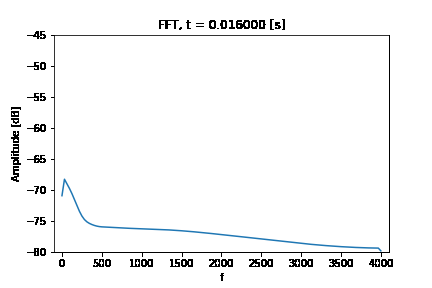

In [36]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

from pathlib import Path
gifPath = Path("abs_filter.gif")

# Display GIF in Jupyter, CoLab, IPython ---- UNCOMMENT LINES BELOW
with open(gifPath,'rb') as f:
   display.Image(data=f.read(), format='png')